<a href="https://colab.research.google.com/github/Supriyasharma12/Rice-Leaf-Disease-Detection/blob/main/MODIFIED_ATTENTION__on_basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MOUNTING dataset from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/MINOR_PROJECT/RICE-DISEASE-DATASET'

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


PREPROCESSING -

Setting all constant values

In [ ]:
BATCH_SIZE=32
IMAGE_SIZE =256
CHANNELS = 3
EPOCHS =40

IMPORTING DATA INTO TENSORFLOW DATASET OBJECT

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/MINOR_PROJECT/RICE-DISEASE-DATASET",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2142 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 1 4 4 2 2 3 0 3 5 5 3 3 3 1 0 5 2 2 4 3 3 0 3 0 0 5 1 4 0 2 2]


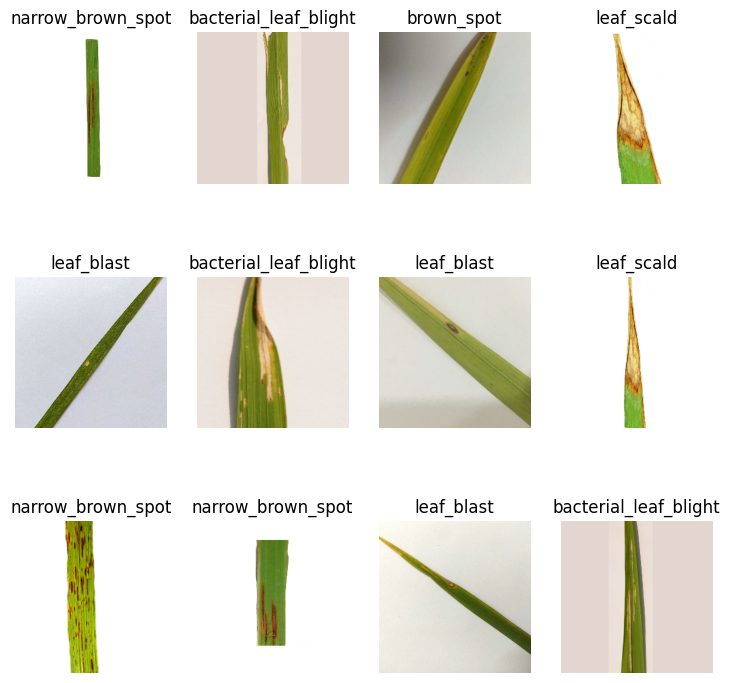

In [ ]:
plt.figure(figsize=(9, 9))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

SPLIT DATASET


In [ ]:
len(dataset)

67

In [ ]:
train_size = 0.8
len(dataset)*train_size

53.6

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

13

In [ ]:
val_size=0.1
len(dataset)*val_size

6.7

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(
    len(train_ds),
    len(val_ds),
    len(test_ds)
)

53 6 8


cache,suffle and prefetching the dataset


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),  # Slight random shift
    layers.RandomBrightness(0.1),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    shared_dense_one = layers.Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal')
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)

    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


In [ ]:
from tensorflow.keras.layers import Input # Import the Input layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = resize_and_rescale(inputs)
n_classes = len(class_names)
# Conv Block 1
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = cbam_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Conv Block 2
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = cbam_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Conv Block 3
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = cbam_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Classification Head
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        132 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 32)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 32)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 256,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 256,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ lambda[0][0],     │
│ (Concatenate)       │ 2)                │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         99 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,878,187 (64.39 MB)

 Trainable params: 16,877,739 (64.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.utils import plot_model

# Replace `model` with your actual model variable if it's named differently
plot_model(model,
           to_file='model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True)

NameError: name 'model' is not defined

In [ ]:
from IPython.display import Image
Image(filename='model_architecture.png')


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.3425 - loss: 4.2866 - val_accuracy: 0.1719 - val_loss: 3.9420
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 845ms/step - accuracy: 0.4889 - loss: 1.2965 - val_accuracy: 0.1719 - val_loss: 9.1651
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 842ms/step - accuracy: 0.5387 - loss: 1.1282 - val_accuracy: 0.1719 - val_loss: 11.7196
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 858ms/step - accuracy: 0.5779 - loss: 1.1154 - val_accuracy: 0.1719 - val_loss: 15.1747
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 845ms/step - accuracy: 0.6318 - loss: 0.9906 - val_accuracy: 0.1719 - val_loss: 18.0540
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 841ms/step - accuracy: 0.6589 - loss: 0.8989 - val_accuracy: 0.1719 - val_loss: 16.6790
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 832ms/step - accuracy: 0.6785 - loss: 0.8248 - val_accuracy: 0.2188 - val_loss: 6.1412
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 44s 832ms/step - accuracy: 0.7006 - loss: 0.8012 - val_ac

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 53}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

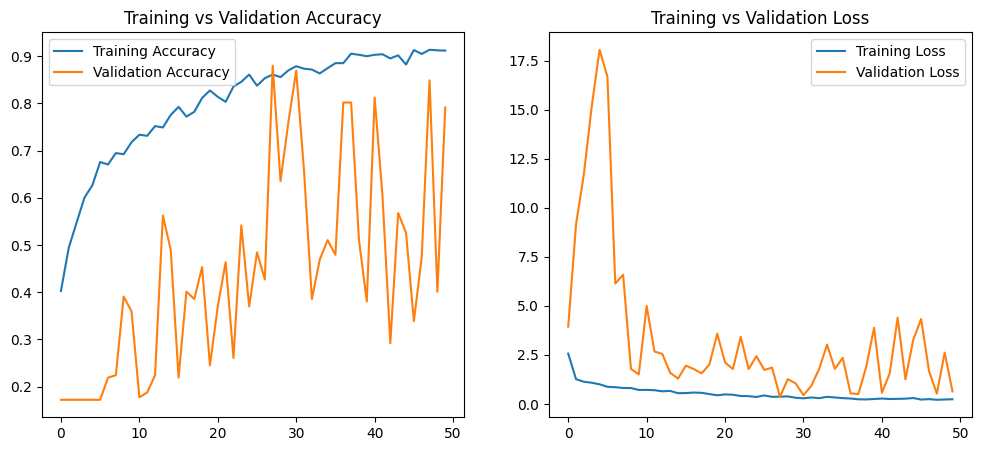

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


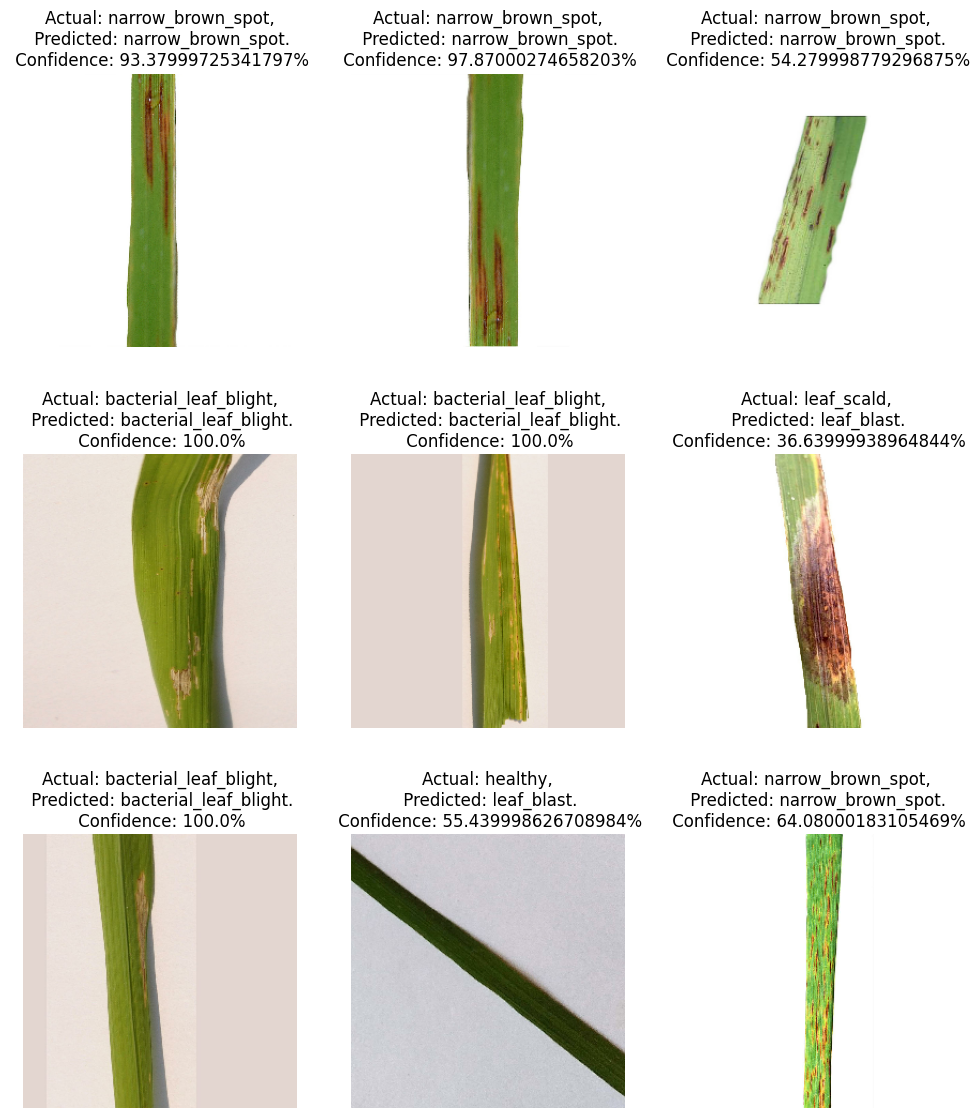

In [ ]:
plt.figure(figsize=(12, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Recreate the test_ds to ensure it has the original structure
test_ds = dataset.skip(int(len(dataset) * (train_size + val_size)))  # Reset test_ds

# Step 1: Collect all test images and labels
test_images = []
test_labels = []

for images, labels in test_ds:  # Use the reset test_ds
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Step 2: Predict in one go
pred_probs = model.predict(test_images, verbose=0)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_labels

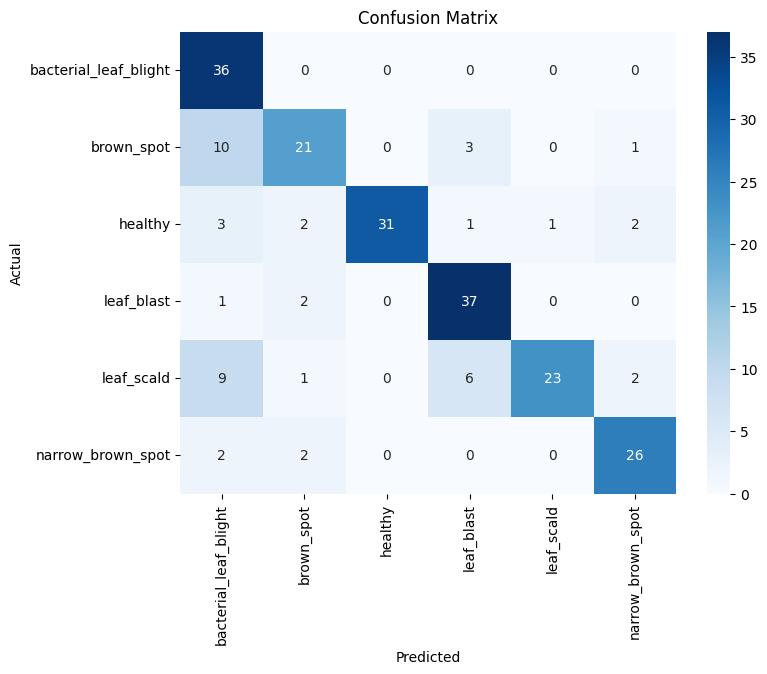

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names_list = list(class_names)  # Assuming you have this

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names_list,
            yticklabels=class_names_list)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install pydot
!apt-get install graphviz -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from tensorflow.keras.utils import plot_model

# Replace `model` with your actual model variable if it's named differently
plot_model(model,
           to_file='model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True)


NameError: name 'model' is not defined

In [ ]:
from IPython.display import Image
Image(filename='model_architecture.png')
